In [1]:
import pandas as pd
from pyproj import Proj, transform
import fiona
from fiona.crs import from_epsg
import logging
import sys
from aabbtree import AABB, AABBTree
import math
from scipy.spatial import distance
import copy
from shapely.geometry import mapping, Polygon
import random

# outProj = Proj(init='epsg:3857')
# inProj = Proj(init='epsg:4326') # It is equal to WSG

In [2]:
# Parametros

espacamento = 50
n = 20 # multiplicador da area de amortização

In [3]:
# Carregar base em metros da area de preservação do chico mendes
chico_mendes = fiona.open("chico_mendes/area_chico_mendes.shp")
print (chico_mendes.schema)

{'properties': OrderedDict([('id', 'float:19'), ('Unidade_de', 'str:254'), ('Categoria', 'str:254'), ('Ano_de_Cri', 'int:9'), ('Zoneamento', 'str:254'), ('Área_hecta', 'float:33.15'), ('Jurisdição', 'str:254'), ('Plano_de_M', 'str:254')]), 'geometry': 'Polygon'}


In [4]:
listaCoordenadas = chico_mendes[0]['geometry']['coordinates']

In [5]:
# retirar ponto x máximo e ponto x mínimo, referente a projeção 3857
# analogo para o ymin e ymax

xmin = 999999999999999
xmax = -99999999999999
ymax = xmax
ymin = xmin
for elem in listaCoordenadas[0]:
    
    if elem[0] > xmax:
        xmax = elem[0]
    elif elem[0] < xmin:
        xmin = elem[0]
        
    if elem[1] > ymax:
        ymax = elem[1]
    elif elem[1] < ymin:
        ymin = elem[1]

In [6]:
print('X Max: ', xmax, '\nX Min: ', xmin)
print('YMax: ', ymax, '\nY Min: ', ymin)

X Max:  -4838636.088731658 
X Min:  -4839587.213704263
YMax:  -2634641.478797528 
Y Min:  -2635360.089792147


In [7]:
yminAmortizado = ymin + (-n*espacamento) 
ymaxAmortizado = ymax + (n*espacamento) 
xminAmortizado = xmin + (-n*espacamento) 
xmaxAmortizado = xmax + (n*espacamento)

In [8]:
print('X Max: ', xmaxAmortizado, '\nX Min: ', xminAmortizado)
print('YMax: ', ymaxAmortizado, '\nY Min: ', yminAmortizado)

X Max:  -4837636.088731658 
X Min:  -4840587.213704263
YMax:  -2633641.478797528 
Y Min:  -2636360.089792147


In [9]:
tree = AABBTree()

treeEstudo = AABBTree()
# (xmin, xmax), (ymin, ymax)
area_estudo = AABB([(xmin, xmax), (ymin, ymax)])

area_amortizada = AABB([(xminAmortizado, xmaxAmortizado), (yminAmortizado, ymaxAmortizado)])


In [10]:
# aabb2 = AABB([(10,15), (10,15)])

tree.add(area_amortizada, 'envol')
treeEstudo.add(area_estudo)
a = tree.does_overlap(area_estudo)

# print(a)


In [11]:
escolas = fiona.open("Mapas_sim/shapes_sim_meters/escola_metros.shp")
print (escolas.schema)

{'properties': OrderedDict([('INEP', 'int:9'), ('Escola', 'str:254'), ('Rede', 'str:254'), ('Localizaçã', 'str:254'), ('Município', 'str:254'), ('Bairro', 'str:254'), ('Endereço', 'str:254'), ('Telefone', 'str:254'), ('Total_Matr', 'float:19'), ('Infantil', 'float:19'), ('Creche', 'float:19'), ('PreEscola', 'float:19'), ('Fundamenta', 'float:19'), ('Fundament0', 'float:19'), ('Fundament1', 'float:19'), ('Ensino_Med', 'float:19'), ('Profission', 'int:9'), ('EJA', 'int:9'), ('Especial', 'int:9'), ('Latitude', 'float:33.15'), ('Longitude', 'float:33.15')]), 'geometry': 'Point'}


In [12]:
listaEscolas = []

for escola in escolas:
    x, y = escola['geometry']['coordinates']
    
    t = AABB([(x, x), (y, y)])
    
    if(tree.does_overlap(t)):
        listaEscolas.append(escola)
    

In [13]:
sink_schema = escolas.schema.copy()
with fiona.open(
        'escola_estudo.shp', 'w',
        crs=from_epsg(3857),
        driver=escolas.driver,
        schema=sink_schema,
        ) as sink:
    
    for e in listaEscolas:
        sink.write(e)

In [14]:
saude = fiona.open("Mapas_sim/shapes_sim_meters/saude_metros.shp")
print (saude.schema)

{'properties': OrderedDict([('Município', 'str:254'), ('Código_CNE', 'str:254'), ('Razão_Soci', 'str:254'), ('Estabeleci', 'str:254'), ('CNPJ_Mante', 'str:254'), ('Endereço', 'str:254'), ('Telefone', 'str:254'), ('Email_ou_F', 'str:254'), ('Tipo', 'str:254'), ('Gestão', 'str:254')]), 'geometry': 'Point'}


In [15]:
listaSaude = []

for unidade in saude:
    x, y = unidade['geometry']['coordinates']
    
    t = AABB([(x, x), (y, y)])
    
    if(tree.does_overlap(t)):
        listaSaude.append(unidade)
    

In [16]:
sink_schema = saude.schema.copy()
with fiona.open(
        'saude_estudo.shp', 'w',
        crs=from_epsg(3857),
        driver=saude.driver,
        schema=sink_schema,
        ) as sink:
    
    for e in listaSaude:
        sink.write(e)

In [17]:
onibus = fiona.open("Mapas_sim/shapes_sim_meters/ponto_onibus_metros.shp")
print (onibus.schema)

{'properties': OrderedDict([('Nome_da_Li', 'str:254'), ('Número_da_', 'str:254'), ('Rota', 'str:254')]), 'geometry': 'MultiPoint'}


In [18]:
listaOnibus = []
i = 0
for linha in onibus:
    for ponto in linha['geometry']['coordinates']:

        x, y = ponto
        t = AABB([(x, x), (y, y)])

        if(tree.does_overlap(t)):
            listaOnibus.append(linha)
            break


In [19]:
sink_schema = onibus.schema.copy()
with fiona.open(
        'onibus_estudo.shp', 'w',
        crs=from_epsg(3857),
        driver=onibus.driver,
        schema=sink_schema,
        ) as sink:
    
    for e in listaOnibus:
        sink.write(e)

In [20]:
# xmin com ymax (0,0)
xminAmortizado

-4840587.213704263

In [21]:
xmaxAmortizado - xminAmortizado

2951.1249726051465

In [22]:
math.ceil( (ymaxAmortizado - yminAmortizado)/espacamento )

55

In [23]:
ymaxAmortizado - yminAmortizado

2718.6109946188517

In [24]:
escolas = fiona.open("chico_mendes/escola_estudo.shp")
saude = fiona.open("chico_mendes/saude_estudo.shp")
onibus = fiona.open("chico_mendes/onibus_estudo.shp")
lagoa = fiona.open("chico_mendes/lagoa_metros.shp")
chico_mendes = fiona.open("chico_mendes/area_chico_mendes.shp")

In [25]:
listaL = lagoa[0]['geometry']['coordinates']

xminL = 999999999999999
xmaxL = -99999999999999
ymaxL = -99999999999999
yminL = 999999999999999
for elem in listaL[0]:
    
    if elem[0] > xmaxL:
        xmaxL = elem[0]
    elif elem[0] < xminL:
        xminL = elem[0]
        
    if elem[1] > ymaxL:
        ymaxL = elem[1]
    elif elem[1] < yminL:
        yminL = elem[1]

In [26]:
print('X Max: ', xmaxL, '\nX Min: ', xminL)
print('YMax: ', ymaxL, '\nY Min: ', yminL)
# X Max:  -4838636.088731658 
# X Min:  -4839587.213704263
# YMax:  -2634641.478797528 
# Y Min:  -2635360.089792147

X Max:  -4838842.731881705 
X Min:  -4839666.182415247
YMax:  -2634802.978674988 
Y Min:  -2635081.1750952885


In [27]:
nextX = espacamento
nextY = -espacamento

startX = xminAmortizado
startY = ymaxAmortizado
nowX = startX + nextX
nowY = startY + nextY

var = 0.000000001

idString = 'id'
xString = 'local_x'
yString = 'local_y'
escolaString = 'escola'
onibusString = 'linha_onibus'
saudeString = 'unidade_saude'
chicoString = 'area_parque_cm'
lagoaString = 'area_lagoa_cm'
ocupaString = 'ocupado'

dict_cm = {}

id_ = 0
for i in range(0, math.ceil( (xmaxAmortizado - xminAmortizado)/espacamento )):
    for j in range(0, math.ceil( (ymaxAmortizado - yminAmortizado)/espacamento )):
        
        cm = 0
        l_cm = 0
        ocupa = 1
        listaOnibus = []
        listaEscolas = []
        listaSaude = []
        
        tree = AABBTree()

        # (xmin, xmax), (ymin, ymax)
        area_estudo = AABB([(startX, nowX), (nowY, startY)])
        tree.add(area_estudo, 'envol')
        
        
        t = AABB([(xminL, xmaxL), (yminL, ymaxL)])

        if(tree.does_overlap(t)):
            l_cm = 1
            ocupa = 0
        
        # PARQUE
        t = AABB([(xmin, xmax), (ymin, ymax)])

        if(tree.does_overlap(t)):
            cm = 1
            ocupa = 0   
            
        for linha in onibus:
            for ponto in linha['geometry']['coordinates']:
                x, y = ponto
                t = AABB([(x, x), (y, y)])
                if(tree.does_overlap(t)):
                    listaOnibus.append(linha)
                    ocupa = 1
                    break
        
        for unidade in saude:
            x, y = unidade['geometry']['coordinates']

            t = AABB([(x, x), (y, y)])

            if(tree.does_overlap(t)):
                ocupa = 1
                listaSaude.append(unidade)
        
        
        for escola in escolas:
            x, y = escola['geometry']['coordinates']

            t = AABB([(x, x), (y, y)])

            if(tree.does_overlap(t)):
                listaEscolas.append(escola)
                ocupa = 1
        
        
        dict_cm[id_] = {idString : id_, 'i': i, 'j': j, xString : startX, yString : startY, escolaString : listaEscolas, \
                     saudeString : listaSaude, onibusString : listaOnibus, chicoString : cm, lagoaString : l_cm, ocupaString : ocupa }
        
        
        id_ += 1
        startX = nowX + var
        nowX += nextX
        
    startX = xminAmortizado
    nowX = startX + nextX
    startY = nowY - var
    nowY += nextY
        
        

In [28]:
def neighborhood(xmaxAmortizado, xminAmortizado, ymaxAmortizado, \
yminAmortizado, espacamento, dict_cm, i, j, id_, neigh, escolas, saude, onibus):

    col = math.ceil( (xmaxAmortizado - xminAmortizado)/espacamento )
    row = math.ceil( (ymaxAmortizado - yminAmortizado)/espacamento )
    cell = []

    if neigh == 'moore':

        ocupado = 0
        num_escolas = 0
        linhasOnibus = 0
        postoSaude = 0
        cell.append((i-1)*row+j) # vizinho de cima
        cell.append((i-1)*row+(j+1)) # viz diagonal superior direito
        cell.append(id_ + 1) # vizinho da direita
        cell.append((i+1)*row + (j+1)) # viz diagonal inferior direito
        cell.append((i+1)*row + j) # viz embaixo
        cell.append((i+1)*row + (j+1)) # viz diagonal inferior esquerdo
        cell.append(id_ - 1) # viz esquerdo
        cell.append((i-1)*row + (j-1)) # viz diagonal superior esquerdo

        for c in cell:
            if dict_cm[c]['ocupado']:
                ocupado += dict_cm[c]['ocupado']
            num_escolas += len(dict_cm[c]['escola'])
            linhasOnibus += len(dict_cm[c]['linha_onibus'])
            postoSaude += len(dict_cm[c]['unidade_saude'])
        
        ocupado = ocupado/len(cell)
        num_escolas = num_escolas/len(escolas)
        linhasOnibus = linhasOnibus/len(onibus)
        postoSaude = postoSaude/len(saude)

        return ocupado, num_escolas,linhasOnibus, postoSaude

In [29]:
def dista(xmaxAmortizado, xminAmortizado, ymaxAmortizado, \
yminAmortizado, espacamento, dict_cm, i, j, id_, dist):

    col = math.ceil( (xmaxAmortizado - xminAmortizado)/espacamento )
    row = math.ceil( (ymaxAmortizado - yminAmortizado)/espacamento )

    listaEsc = []
    listaOni = []
    listaSau = []
    for key in dict_cm:
        if len(dict_cm[key]['escola']) > 0:
            listaEsc.append(key)
        if len(dict_cm[key]['linha_onibus']) > 0:
            listaOni.append(key)
        if len(dict_cm[key]['unidade_saude']) > 0:
            listaSau.append(key)


    le = []
    lo = []
    ls = []
    if dist == 'manhattan':

        for e in listaEsc:
            x = int(e/row)
            y = e % row
            d = distance.cityblock([i, j], [x, y])
            le.append(d)

        for o in listaOni:
            x = int(o/row)
            y = o % row
            d = distance.cityblock([i, j], [x, y])
            lo.append(d)

        for s in listaSau:
            x = int(s/row)
            y = s % row
            d = distance.cityblock([i, j], [x, y])
            ls.append(d)

        distE = [l / max(le) for l in le]
        distO = [l / max(lo) for l in lo]
        distS = [l / max(ls) for l in ls]

        return min(distE), min(distO), min(distS)



In [30]:
for key in dict_cm:
    if dict_cm[key]['area_parque_cm']:
        if dict_cm[key]['ocupado']:
            print('pq ocupado')

pq ocupado
pq ocupado


In [31]:
# i = 0
# lagssads = 0
# for key in dict_cm:
#     if dict_cm[key]['area_parque_cm']:
#         print(dict_cm[key]['ocupado'])
#         i+=1
#     if dict_cm[key]['area_lagoa_cm']:
#         lagssads += 1

In [32]:
# print(i, lagssads)

In [33]:
def create_area(nextX, nextY, yminAmortizado, ymaxAmortizado,\
xmaxAmortizado, xminAmortizado, escolas, saude, onibus, lagoa, chico_mendes, \
espacamento, xmax, xmin, ymax, ymin):
    listaL = lagoa[0]['geometry']['coordinates']
    listaCoordenadas = chico_mendes[0]['geometry']['coordinates']
    startX = xminAmortizado
    startY = ymaxAmortizado
    nowX = startX + nextX
    nowY = startY + nextY

    var = 0.000000001

    idString = 'id'
    xString = 'local_x'
    yString = 'local_y'
    escolaString = 'escola'
    onibusString = 'linha_onibus'
    saudeString = 'unidade_saude'
    chicoString = 'area_parque_cm'
    lagoaString = 'area_lagoa_cm'
    ocupaString = 'ocupado'

    listaL = lagoa[0]['geometry']['coordinates']

    xminL = 999999999999999
    xmaxL = -99999999999999
    ymaxL = -99999999999999
    yminL = 999999999999999
    for elem in listaL[0]:

        if elem[0] > xmaxL:
            xmaxL = elem[0]
        elif elem[0] < xminL:
            xminL = elem[0]

        if elem[1] > ymaxL:
            ymaxL = elem[1]
        elif elem[1] < yminL:
            yminL = elem[1]

    dict_cm = {}

    id_ = 0
    for i in range(0, math.ceil( (xmaxAmortizado - xminAmortizado)/espacamento )):
        for j in range(0, math.ceil( (ymaxAmortizado - yminAmortizado)/espacamento )):

            cm = 0
            l_cm = 0
            ocupa = 1
            listaOnibus = []
            listaEscolas = []
            listaSaude = []

            tree = AABBTree()

            # (xmin, xmax), (ymin, ymax)
            area_estudo = AABB([(startX, nowX), (nowY, startY)])
            tree.add(area_estudo, 'envol')

            #LAGOA
            t = AABB([(xminL, xmaxL), (yminL, ymaxL)])
            if(tree.does_overlap(t)):
                l_cm = 1
                ocupa = 0

            #PARQUE
            t = AABB([(xmin, xmax), (ymin, ymax)])
            if(tree.does_overlap(t)):
                cm = 1
                ocupa = 0

            for linha in onibus:
                for ponto in linha['geometry']['coordinates']:
                    x, y = ponto
                    t = AABB([(x, x), (y, y)])
                    if(tree.does_overlap(t)):
                        listaOnibus.append(linha)
                        ocupa = 1
                        break

            for unidade in saude:
                x, y = unidade['geometry']['coordinates']

                t = AABB([(x, x), (y, y)])

                if(tree.does_overlap(t)):
                    ocupa = 1
                    listaSaude.append(unidade)


            for escola in escolas:
                x, y = escola['geometry']['coordinates']

                t = AABB([(x, x), (y, y)])

                if(tree.does_overlap(t)):
                    listaEscolas.append(escola)
                    ocupa = 1


            dict_cm[id_] = {idString : id_, 'i': i, 'j': j, xString : startX, yString : startY, escolaString : listaEscolas, \
                         saudeString : listaSaude, onibusString : listaOnibus, chicoString : cm, lagoaString : l_cm, ocupaString : ocupa }


            id_ += 1
            startX = nowX + var
            nowX += nextX

        startX = xminAmortizado
        nowX = startX + nextX
        startY = nowY - var
        nowY += nextY

    return dict_cm


In [34]:
def simulacao(neigh, dist, dict_temp, xmaxAmortizado, xminAmortizado, \
ymaxAmortizado, yminAmortizado, espacamento, escolas, saude, onibus, pesos, inercia, threshold):
    serie_historica = []
    fim = 1
    neigh = neigh
    dist = dist
    d0 = copy.deepcopy(dict_temp)
    serie_historica.append(d0)

    space_to_occup = 0
    occupied = 0
    lag = 0
    parq = 0

    for key in d0:
        if (d0[key]['area_parque_cm'] == 1) and (d0[key]['area_lagoa_cm'] == 0):
            space_to_occup += 1
        if d0[key]['area_lagoa_cm']:
            lag += 1
        if d0[key]['area_parque_cm']:
            parq += 1

    print('to: ', space_to_occup)

    log = []
    log_disc = []
    t = 0
    while ((occupied < (space_to_occup-2)) and (t < 100)):
#     for u in range(0, 10):
        occ_now = 0
        for key in dict_temp:
            if (dict_temp[key]['area_parque_cm']):
                i = dict_temp[key]['i']
                j = dict_temp[key]['j']
                id_ = dict_temp[key]['id']
                ocupacao_per, escola_per, onibus_per, saude_per = neighborhood(xmaxAmortizado, xminAmortizado, ymaxAmortizado, \
                yminAmortizado, espacamento, dict_temp, i, j, id_, neigh, escolas, saude, onibus)
                distEscola, distOnibus, distSaude = dista(xmaxAmortizado, xminAmortizado, ymaxAmortizado, \
                yminAmortizado, espacamento, dict_temp, i, j, id_, dist)

                N = ocupacao_per*pesos[0]
                S = (escola_per*pesos[1] + onibus_per*pesos[2] + saude_per*pesos[3])/3
                D = (((1 - distEscola) + (1 - distOnibus) + (1 - distSaude)) / 3)*pesos[4]
                I = inercia
                P = 1
                E = 1

                if dict_temp[key]['area_lagoa_cm']:
                    P = 0

                funct = ((N + S + D - I))*P*E
                if funct < 0.0:
                    funct = 0.0
#                 print(funct)
                
                
                f = random.random()
                if funct > f:
                    if dict_temp[key]['ocupado'] == 0:
#                         print('ocupei')
                        dict_temp[key]['ocupado'] = 1
                        occupied += 1
                        occ_now += 1

#         d = copy.deepcopy(dict_temp)
        serie_historica.append(copy.deepcopy(dict_temp))
        log.append(['iteracao: ', t, ', ' 'space occ: ', occupied, '\n'])
        log_disc.append(['iteracao: ', t, ', ' 'space occ now: ', occ_now, '\n'])
        t+=1
        print('iteracao: ', t, 'space occ: ', occupied)


    print('final: ',occupied)

    return serie_historica, dict_temp, t, log, log_disc


In [35]:
def write_ocupacao_por_tempo(serie, name, nextX, nextY):
    # Here's an example Shapely geometry
    # poly = Polygon(coordendas)

    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }
    i = 0

    for i in range(0, len(serie)):
        name_ = name + '_' + str(i) + '.shp'
        sink_list = []
        for key in serie[i]:
            if serie[i][key]['area_parque_cm']:
                if serie[i][key]['ocupado']:
                    sink_list.append(serie[i][key])
                    # Write a new Shapefile

        outpath = name_
        with fiona.open(outpath, 'w', crs=from_epsg(3857), driver='ESRI Shapefile', schema=schema) as c:

            for s in sink_list:
                x = s['local_x']
                y = s['local_y']

                p = [ (x, y), (x+nextX, y), (x+nextX, y + nextY), (x, y+nextY)]
                poly = Polygon(p)
                c.write({
                    'geometry': mapping(poly),
                    'properties': {'id': s['id']},
                })



In [36]:
dict_cm = create_area(nextX, nextY, yminAmortizado, ymaxAmortizado,\
xmaxAmortizado, xminAmortizado, escolas, saude, onibus, lagoa, chico_mendes, \
espacamento, xmax, xmin, ymax, ymin)

In [37]:
aurelio = copy.deepcopy(dict_cm)


In [38]:
neigh = 'moore'
dist = 'manhattan'
# vizinhança, escola, pontos de onibus, saude, distancia
pesos = [0.4, 0.3, 0.2, 0.1, 0.9]
threshold = 0.10
inercia = 0.65

In [39]:
serie, dict_cm, tempo, log, log_dist = simulacao(neigh, dist, aurelio, xmaxAmortizado, xminAmortizado, ymaxAmortizado, \
yminAmortizado, espacamento, escolas, saude, onibus, pesos, inercia, threshold )

to:  240
iteracao:  1 space occ:  7
iteracao:  2 space occ:  17
iteracao:  3 space occ:  21
iteracao:  4 space occ:  24
iteracao:  5 space occ:  32
iteracao:  6 space occ:  40
iteracao:  7 space occ:  45
iteracao:  8 space occ:  55
iteracao:  9 space occ:  59
iteracao:  10 space occ:  61
iteracao:  11 space occ:  64
iteracao:  12 space occ:  71
iteracao:  13 space occ:  84
iteracao:  14 space occ:  84
iteracao:  15 space occ:  90
iteracao:  16 space occ:  96
iteracao:  17 space occ:  102
iteracao:  18 space occ:  108
iteracao:  19 space occ:  110
iteracao:  20 space occ:  113
iteracao:  21 space occ:  113
iteracao:  22 space occ:  118
iteracao:  23 space occ:  120
iteracao:  24 space occ:  122
iteracao:  25 space occ:  122
iteracao:  26 space occ:  124
iteracao:  27 space occ:  128
iteracao:  28 space occ:  128
iteracao:  29 space occ:  130
iteracao:  30 space occ:  133
iteracao:  31 space occ:  134
iteracao:  32 space occ:  140
iteracao:  33 space occ:  142
iteracao:  34 space occ:  1

In [ ]:
write_ocupacao_por_tempo(serie, 'teste', nextX, nextY)


In [ ]:
for key in dict_cm:
    if dict_cm[key]['area_parque_cm']:
        print(dict_cm[key]['ocupado'])

In [ ]:
def debug_(serie, name, nextX, nextY):
    # Here's an example Shapely geometry
    # poly = Polygon(coordendas)

    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }
    i = 0
#     path = 'mnt/hdd/Personal/Documentos/MSc/sim/ouput/'
#     path = 'home/none/Downloads/nath/'
#     for i in range(0, len(serie)):
    name_ = name + '_' + str(i) + '.shp'
    sink_list = []
    for key in serie:
        if serie[key]['ocupado']:
#                 if serie[i][key]['ocupado']:
            sink_list.append(serie[key])
            # Write a new Shapefile
        
    outpath = name_
    with fiona.open(outpath, 'w', crs=from_epsg(3857), driver='ESRI Shapefile', schema=schema) as c:

        for s in sink_list:
            x = s['local_x']
            y = s['local_y']

            p = [ (x, y), (x+nextX, y), (x+nextX, y + nextY), (x, y+nextY)]
            poly = Polygon(p)
            c.write({
                'geometry': mapping(poly),
                'properties': {'id': s['id']},
            })




In [ ]:
debug_(aurelio, 'estado_inicial', nextX, nextY)

In [40]:
def logging(log, name):
    name = name + '.txt'

    with open(name, 'w') as f:
        for elem in log:
            for item in elem:
                f.write(str(item))

#             f.write('\n')

In [41]:
logging(log, 'log')

In [43]:
logging(log_dist, 'log_disc')

In [69]:
new_occ_by_year = []
occ_cumulative = []
for l in log_dist:
    new_occ_by_year.append(l[3])
    
for l in log:
    occ_cumulative.append(l[3])

In [71]:
occ_cumulative


[7,
 17,
 21,
 24,
 32,
 40,
 45,
 55,
 59,
 61,
 64,
 71,
 84,
 84,
 90,
 96,
 102,
 108,
 110,
 113,
 113,
 118,
 120,
 122,
 122,
 124,
 128,
 128,
 130,
 133,
 134,
 140,
 142,
 144,
 145,
 149,
 151,
 152,
 155,
 155,
 156,
 159,
 159,
 160,
 160,
 163,
 164,
 167,
 169,
 170,
 171,
 172,
 172,
 172,
 175,
 177,
 178,
 178,
 179,
 181,
 181,
 181,
 181,
 182,
 183,
 185,
 185,
 186,
 188,
 189,
 190,
 191,
 191,
 192,
 192,
 192,
 193,
 194,
 194,
 195,
 196,
 196,
 197,
 197,
 197,
 197,
 198,
 199,
 199,
 199,
 199,
 199,
 199,
 200,
 200,
 200,
 202,
 202,
 204,
 204]

In [51]:
import matplotlib.pyplot as plt

In [74]:
def plot1(data_acc, steps, label):
    c = range(len(data_acc))
    fig = plt.figure()
    limit = int(max(data_acc) + int(0.2*max(data_acc)))
    fig.add_subplot(122)
    ax = plt.axes()
    ax.plot(c, data_acc, 'k')
    plt.yticks(range(0, limit, 20))
    plt.xticks(range(0, steps+1, 10))
    plt.title(label)
    plt.ylabel("Células ocupadas")
    plt.xlabel("Ano")
    plt.grid()
    plt.show()

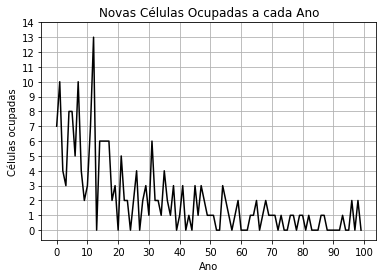

In [68]:
plot1(new_occ_by_year, 100, 'Novas Células Ocupadas a cada Ano')

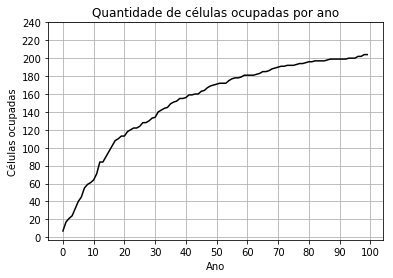

In [75]:
plot1(occ_cumulative, 100, 'Quantidade de células ocupadas por ano')

In [99]:
def plotTime(listOfTimes):

    for l in range(len(listOfTimes)):
        ax = plt.axes()
        ax.bar(l, listOfTimes[l], align='center', width=0.5)

    # fig = plt.figure(figsize=(1,1))
    plt.title("Novas Células Ocupadas a cada Ano")
#     plt.legend(listOfMethods)
    plt.ylabel("Células ocupadas")
    plt.xlabel("Ano")
    plt.xticks(range(0, 100+1, 10))
    plt.show()

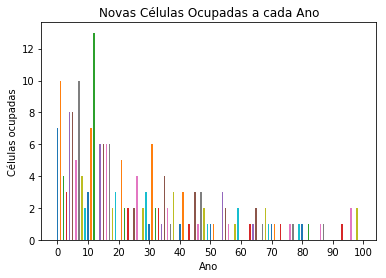

In [100]:
plotTime(new_occ_by_year)